<a href="https://colab.research.google.com/github/LilianYou/dark-lily/blob/master/4_fcn_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PSYCH 239: Week 2: Fully Connected Neural Network for Visual Classification


In [0]:
import torch
from torchvision import datasets, transforms

In [0]:
class toOneHot(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def __call__(self, integer):
        y_onehot = torch.zeros(self.num_classes)
        y_onehot[integer]=1
        return y_onehot

In [0]:
train_set = datasets.MNIST('./data',
                           train=True, download=True,
                           transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                             ]),
                           target_transform = toOneHot(num_classes = 10),)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)

In [0]:
test_set = datasets.MNIST('./data',
                           train=False, download=True,
                           transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                             ]),
                           target_transform = toOneHot(num_classes = 10),)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

In [0]:
net_cuda = torch.nn.Sequential(torch.nn.Linear(784, 300),
                                  torch.nn.ReLU(), #this is an activation function
                                  torch.nn.Linear(300, 300),
                                  torch.nn.ReLU(), #this is an activation function
                                  torch.nn.Linear(300, 10),
                                  torch.nn.ReLU(),
                               ).cuda()

In [0]:
mse_loss = torch.nn.MSELoss()
opt = torch.optim.Adam(net_cuda.parameters(), lr=1e-3, weight_decay=1e-3)

In [0]:
def train_step(x, t, net, opt_fn, loss_fn):
    t_cuda = t.cuda()
    y_cuda = net(x.cuda())
    loss_cuda = loss_fn(y_cuda, t_cuda)
    loss_cuda.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss_cuda.cpu()

In [0]:
x,t = next(iter(train_loader))
train_step(x.view(-1,784), t, net_cuda, opt, mse_loss)

tensor(0.0950, grad_fn=<CopyBackwards>)

Make prediction

In [0]:
for x,t in iter(test_loader):   
    y = net_cuda(x.view(-1,784).cuda()).cpu()

In [0]:
y.argmax(1)

tensor([3, 3, 5, 3, 8, 6, 5, 3, 9, 3, 6, 5, 3, 3, 3, 5, 9, 8, 9, 5, 3, 3, 1, 6,
        0, 0, 3, 9, 0, 7, 5, 5, 3, 3, 9, 9, 5, 3, 5, 9, 3, 9, 6, 3, 6, 5, 3, 9,
        5, 3, 1, 3, 5, 3, 6, 1, 5, 5, 3, 1, 9, 0, 5, 3, 3, 3, 3, 6, 1, 6, 1, 9,
        3, 9, 3, 6, 3, 6, 9, 3, 3, 5, 9, 9, 5, 3, 3, 1, 3, 9, 9, 5, 1, 5, 3, 1,
        5, 5, 1, 6])

Calculate accuracy

In [0]:
torch.mean((t.argmax(1) == y.argmax(1)).float())

tensor(0.3800)

Train the network over multiple epochs

In [0]:
acc_hist_train = []
acc_hist_test = []
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler
subset_loader = torch.utils.data.DataLoader(train_set, batch_size=100, sampler=SubsetRandomSampler(range(300)))

for epoch in range(200):
    acc_batch = []
    net_cuda.train()
    for x, t in iter(subset_loader):   
        loss_ = train_step(x.view(-1,784), t, net_cuda, opt, mse_loss)
        y = net_cuda(x.view(-1,784).cuda()).cpu()
        acc_batch.append(torch.mean((t.argmax(1) == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_)

    net_cuda.eval()
    acc_batch = []
    for x,t in iter(test_loader):   
        y = net_cuda(x.view(-1,784).cuda()).cpu()
        acc_batch.append(torch.mean((t.argmax(1) == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch))) 
    

tensor(0.0576, grad_fn=<CopyBackwards>)
tensor(0.0318, grad_fn=<CopyBackwards>)
tensor(0.0254, grad_fn=<CopyBackwards>)
tensor(0.0174, grad_fn=<CopyBackwards>)
tensor(0.0143, grad_fn=<CopyBackwards>)
tensor(0.0114, grad_fn=<CopyBackwards>)
tensor(0.0071, grad_fn=<CopyBackwards>)
tensor(0.0047, grad_fn=<CopyBackwards>)
tensor(0.0052, grad_fn=<CopyBackwards>)
tensor(0.0062, grad_fn=<CopyBackwards>)
tensor(0.0037, grad_fn=<CopyBackwards>)
tensor(0.0044, grad_fn=<CopyBackwards>)
tensor(0.0019, grad_fn=<CopyBackwards>)
tensor(0.0008, grad_fn=<CopyBackwards>)
tensor(0.0037, grad_fn=<CopyBackwards>)
tensor(0.0018, grad_fn=<CopyBackwards>)
tensor(0.0026, grad_fn=<CopyBackwards>)
tensor(0.0005, grad_fn=<CopyBackwards>)
tensor(0.0016, grad_fn=<CopyBackwards>)
tensor(0.0024, grad_fn=<CopyBackwards>)
tensor(0.0015, grad_fn=<CopyBackwards>)
tensor(0.0024, grad_fn=<CopyBackwards>)
tensor(0.0024, grad_fn=<CopyBackwards>)
tensor(0.0014, grad_fn=<CopyBackwards>)
tensor(0.0025, grad_fn=<CopyBackwards>)


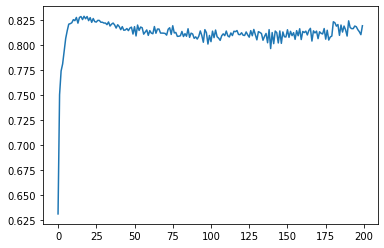

In [0]:
import pylab
pylab.plot(acc_hist_test)